In [1]:
import pandas as pd
import numpy as np
import random

from PIL import Image

import os
import glob

import matplotlib.pyplot as plt
plt.rc('image',cmap='gray')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [2]:
import tensorflow as tf
#tf.test.is_built_with_cuda()
#tf.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability=None)
#tf.config.list_physical_devices('GPU')

In [3]:
#categories = ["straightCross","ellipse","hexagon","square","triangle","line"]
categories = ["angleCross","ellipse","fullstar","hexagon","line","square","straightCross","triangle"]
im_width = 64
im_height = 64

In [30]:
from PIL import ImageFont
import visualkeras

In [80]:
data = []
target = []

for cat in categories:
    filelist = glob.glob('dataset/training_set/'+cat+'/*.jpg')
    target.extend([cat for _ in filelist])
    data.extend([np.array(Image.open(fname).resize((im_width, im_height)).convert("L",palette=Image.WEB,colors=8)) for fname in filelist])
#
data_array = np.stack(data, axis=0)

In [81]:
data_array.shape

(1831, 64, 64)

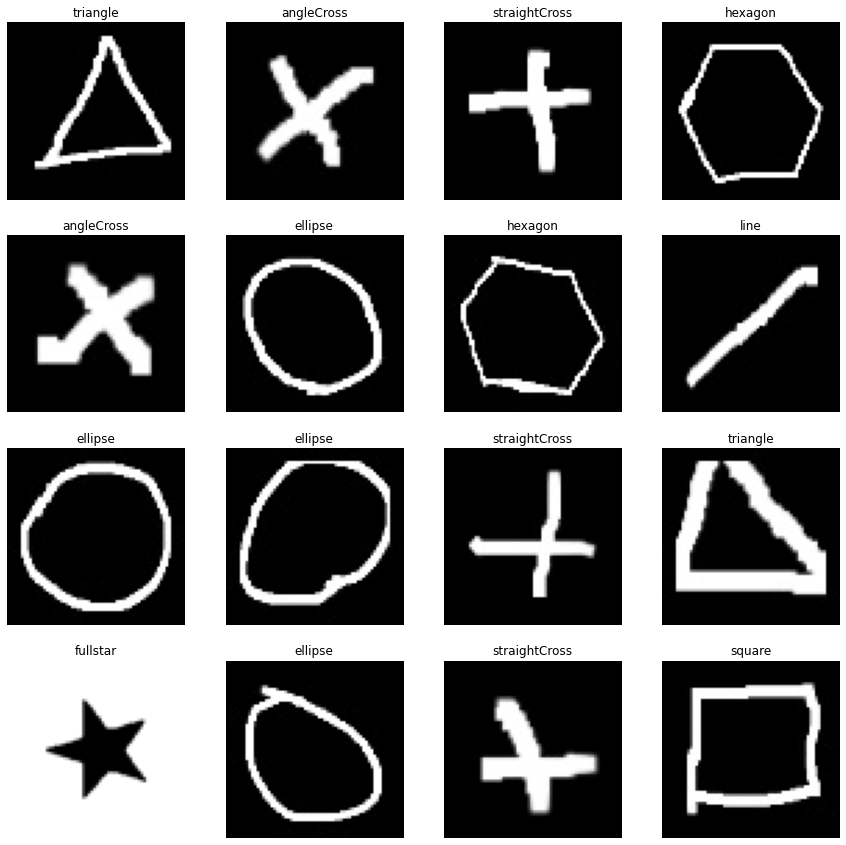

In [102]:
fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(4,4)

for line in range(0,4):
    for row in range(0,4):
        num_image = random.randint(0,data_array.shape[0])
        ax = fig.add_subplot(gs[line,row])
        ax.axis('off')
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image]);


In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_array, np.array(target), test_size=0.2, stratify=target)

In [9]:
X_test_norm = np.round((X_test/255),7).copy()
X_train_norm = np.round((X_train/255),7).copy()




In [10]:
print(X_train_norm.max())
print(X_train_norm.min())

1.0
0.0


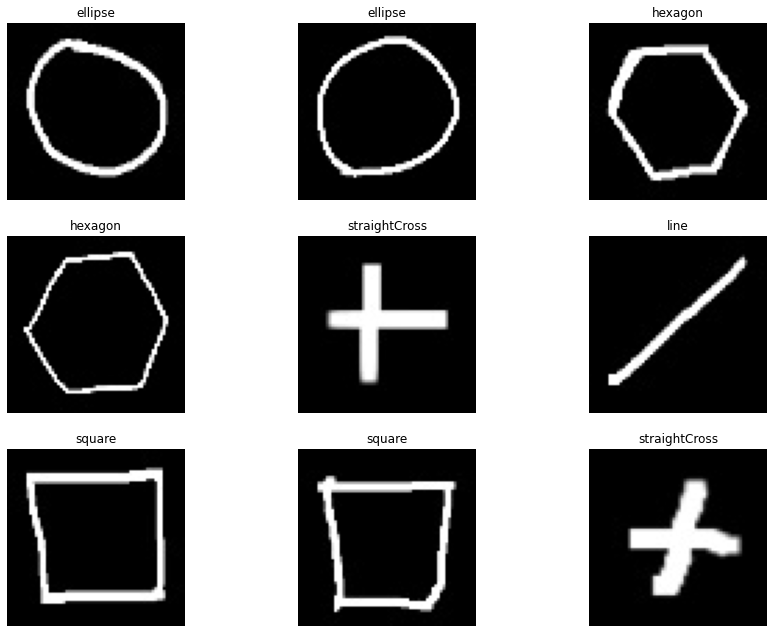

In [11]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, X_train_norm.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(y_train[num_image])
        ax.imshow(X_train_norm[num_image]);

In [12]:
display(np.array(y_train).shape)
display(np.unique(y_train))
display(np.array(y_test).shape)
display(np.unique(y_test))

(1464,)

array(['angleCross', 'ellipse', 'fullstar', 'hexagon', 'line', 'square',
       'straightCross', 'triangle'], dtype='<U13')

(367,)

array(['angleCross', 'ellipse', 'fullstar', 'hexagon', 'line', 'square',
       'straightCross', 'triangle'], dtype='<U13')

In [13]:
encoder = LabelEncoder().fit(y_train)

In [14]:
y_train_cat = encoder.transform(y_train)
y_test_cat = encoder.transform(y_test)

In [15]:
y_train_oh = to_categorical(y_train_cat)
y_test_oh = to_categorical(y_test_cat)

In [16]:
pd.DataFrame(y_test_oh).head()

0    1    2    3    4    5    6    7
0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0

In [17]:
X_train_norm = X_train_norm.reshape(-1, 64, 64, 1)
X_test_norm = X_test_norm.reshape(-1, 64, 64, 1)
X_test_norm.shape

(367, 64, 64, 1)

In [18]:
def initialize_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(im_height, im_width, 1), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(8, activation='softmax'))

    return model

In [19]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 128)        0

In [20]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics="accuracy")
    return model

In [59]:
model = initialize_model()
model = compile_model(model)
es = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(X_train_norm, y_train_oh,
                    batch_size=4,
                    epochs=30,
                    validation_split=0.2,
                    )

Epoch 1/30
293/293 [==============================] - 6s 14ms/step - loss: 0.7099 - accuracy: 0.7301 - val_loss: 0.1469 - val_accuracy: 0.9522
Epoch 2/30
293/293 [==============================] - 4s 13ms/step - loss: 0.1868 - accuracy: 0.9488 - val_loss: 0.0857 - val_accuracy: 0.9795
Epoch 3/30
293/293 [==============================] - 4s 13ms/step - loss: 0.1028 - accuracy: 0.9667 - val_loss: 0.0717 - val_accuracy: 0.9761
Epoch 4/30
293/293 [==============================] - 4s 12ms/step - loss: 0.0596 - accuracy: 0.9804 - val_loss: 0.0473 - val_accuracy: 0.9829
Epoch 5/30
293/293 [==============================] - 4s 12ms/step - loss: 0.0605 - accuracy: 0.9804 - val_loss: 0.0462 - val_accuracy: 0.9898
Epoch 6/30
293/293 [==============================] - 4s 14ms/step - loss: 0.0407 - accuracy: 0.9906 - val_loss: 0.0286 - val_accuracy: 0.9898
Epoch 7/30
293/293 [==============================] - 4s 15ms/step - loss: 0.0063 - accuracy: 0.9974 - val_loss: 0.1575 - val_accuracy: 0.9795

Evaluate on test data
Test Loss: 0.08744538063183427 %
Test Accuracy 100.0 %


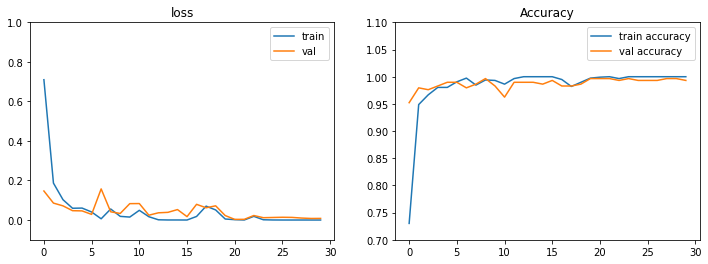

In [60]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(-0.1, 1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.7, 1.1)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(history, title='', axs=None, exp_name="");

arr = model.evaluate(X_test_norm, y_test_oh, verbose=0);
print("Evaluate on test data")
print("Test Loss:",arr[0]*100,"%")
print("Test Accuracy",arr[1]*100,"%")

In [61]:
arr = model.evaluate(X_test_norm, y_test_oh, verbose=0);
print("Evaluate on test data")
print("Test Loss:",arr[0]*100,"%")
print("Test Accuracy",arr[1]*100,"%")


Evaluate on test data
Test Loss: 0.08744538063183427 %
Test Accuracy 100.0 %


In [62]:
predictions = model.predict(X_test_norm)

12/12 [==============================] - 0s 11ms/step


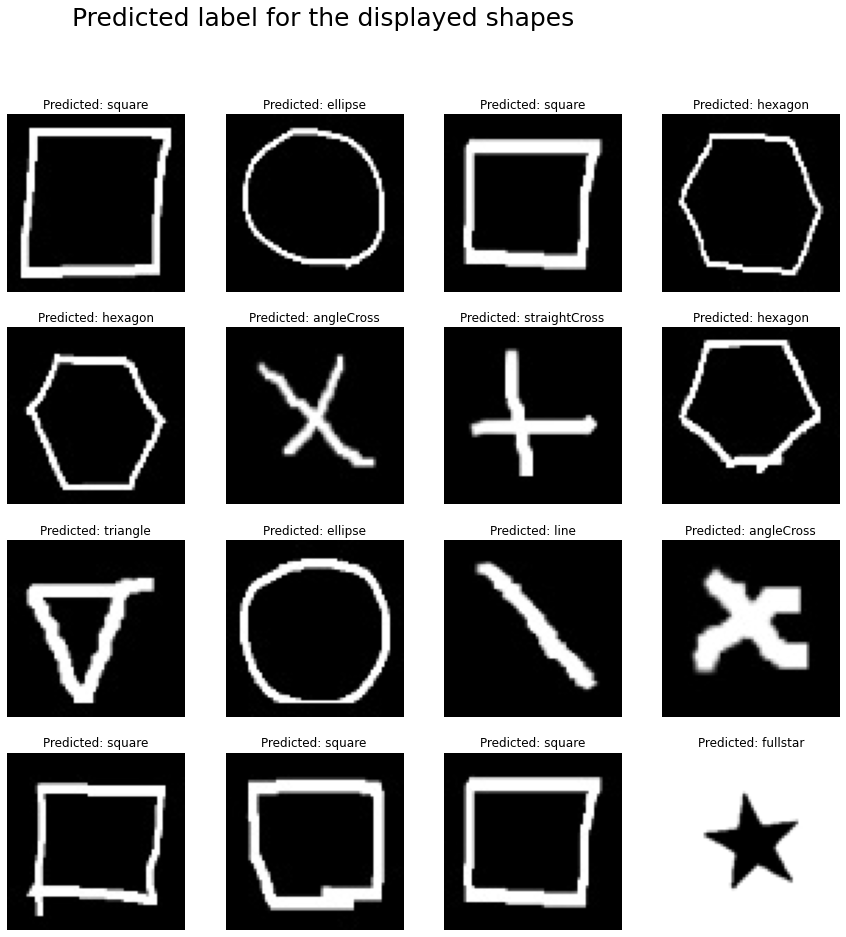

In [104]:
fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 4):
    for row in range(0, 4):
        num_image = random.randint(0, X_test_norm.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title("Predicted: " + categories[list(np.round(predictions[num_image])).index(1)])
        ax.imshow(X_test_norm[num_image]);
fig.suptitle("Predicted label for the displayed shapes", fontsize=25, x=0.42);

In [64]:
print("Evaluate on test data")
results = model.evaluate(X_test_norm, y_test_oh)
print("test loss, test acc:", results)

Evaluate on test data
12/12 [==============================] - 0s 31ms/step - loss: 8.7445e-04 - accuracy: 1.0000
test loss, test acc: [0.0008744538063183427, 1.0]


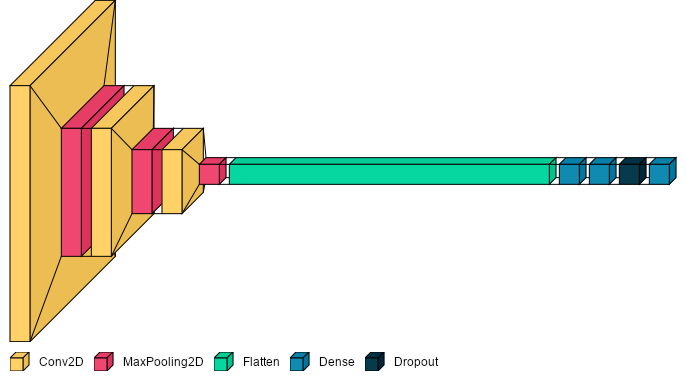

In [66]:

font = ImageFont.truetype("arial.ttf",12)
visualkeras.layered_view(model,legend=True,font=font)

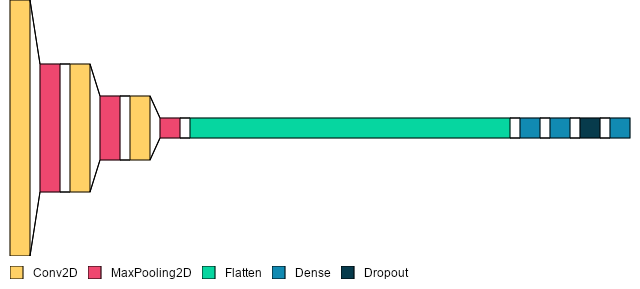

In [67]:
visualkeras.layered_view(model,legend=True,font=font,draw_volume=False)

In [38]:
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [68]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test_norm)
Y_pred_class = np.argmax(Y_pred,axis=1)

Y_true=np.argmax(y_test_oh,axis=1)

cnfmtx = confusion_matrix(Y_true,Y_pred_class)



12/12 [==============================] - 0s 10ms/step
